In [137]:
import numpy as np
import os
import re
import scipy.io as scio
import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

import math
from keras.layers import Activation
from keras.layers import GlobalAveragePooling1D
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import Callback
from keras.utils import plot_model

from sklearn.manifold import TSNE
import seaborn as sns
from scipy import io


### 获取数据

In [138]:
# raw_num = 240
# col_num = 2000

# class Data(object):
    
#     def __init__(self):
#         self.data = self.get_data()
#         self.label = self.get_label()
        
#     def file_list(self):
#         return os.listdir('C:/Users/KQiao/Desktop/初稿素材4.16/代码/data483/')
    
#     def get_data(self):
#         file_list = self.file_list()
#         for i in range(len(file_list)):
#             file = scio.loadmat('C:/Users/KQiao/Desktop/初稿素材4.16/代码/data483/{}'.format(file_list[i])) # 读取某个mat文件
#             for k in file.keys(): # 获取 DE 相关数据
#                 file_matched = re.match('X\d{3}_DE_time', k)
#                 if file_matched:
#                     key = file_matched.group()
#             if i == 0:
#                 data = np.array(file[key][0:480000].reshape(raw_num,col_num))
#             else:
#                 data = np.vstack((data, file[key][0:480000].reshape(raw_num,col_num))) # 按行堆叠
#         return data
    
#     def get_label(self):
#         file_list = self.file_list()
#         title = np.array([i.replace('.mat', '') for i in file_list]) # 用文件名作为 标签
#         label = title[:, np.newaxis] # 增加一个维度
#         label_copy = np.copy(label)
#         for _ in range(raw_num-1):
#             label = np.hstack((label, label_copy))
#         return label.flatten()

In [139]:
# Data = Data()
# data = Data.data # (2400, 2000)
# label = Data.label # (2400,)
# lb = LabelBinarizer()
# y = lb.fit_transform(label) # one-hot 编码

# # Wiener filtering 主要用于从带噪的观测信号种提取出所需要的干净信号
# data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

# print(data.shape)
# print(y.shape)

# # downsampling 下采样，每隔8个点取一个值
# index = np.arange(0,2000, 8)
# data_samp = data_wiener[:, index]
# print(data_samp.shape)

In [140]:
# # 7071-9945-0.2-0.003   225226-?-0.001 , random_state=6
# X_train, X_testss, y_train, y_testss = train_test_split(data_samp, y, test_size=0.3, shuffle=True)# yes-2324 4243 4950 306307
# X_test, X_valid, y_test, y_valid = train_test_split(X_testss, y_testss, test_size=0.5, shuffle=True) # 
# print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape)

In [141]:
# # 用于保存划分的数据集
# from scipy import io

# io.savemat('traindata_100_48.mat',{'data': X_train, 'label': y_train})
# io.savemat('validdata_100_48.mat',{'data': X_valid, 'label': y_valid})
# io.savemat('testdata_100_48.mat',{'data': X_test, 'label': y_test})

In [142]:
train_file = scio.loadmat(r'C:\Users\KQiao\Desktop\初稿素材4.16\代码\best result（分类较均匀）\4.2_100\traindata_100.mat')
X_train = train_file['data']
y_train = train_file['label']
print(X_train.shape, y_train.shape)

(1680, 250) (1680, 10)


In [143]:
valid_file = scio.loadmat(r'C:\Users\KQiao\Desktop\初稿素材4.16\代码\best result（分类较均匀）\4.2_100\validdata_100.mat')
X_valid = valid_file['data']
y_valid = valid_file['label']
print(X_valid.shape, y_valid.shape)

(360, 250) (360, 10)


In [144]:
test_file = scio.loadmat(r'C:\Users\KQiao\Desktop\初稿素材4.16\代码\best result（分类较均匀）\4.2_100\testdata_100.mat')
X_test = test_file['data']
y_test = test_file['label']
print(X_test.shape, y_test.shape)

(360, 250) (360, 10)


In [145]:
def eca_block(input_feature, b=1, gamma=2, name=""):
    channel = input_feature._keras_shape[-1] # 输入格式(batchsize, stpes, channels)
    kernel_size = int(abs((math.log(channel, 2) + b) / gamma))
    kernel_size = kernel_size if kernel_size % 2 else kernel_size + 1

    # 输入(batch_size, steps, features) (None, 27, 30)  输出(batch_size, features)(None, 30) 
    avg_pool = GlobalAveragePooling1D()(input_feature)
    
    x = Reshape((-1, 1))(avg_pool) #(None, 30, 1)
    # 输入(batch_size, steps, input_dim)(None, 30, 1)      输出(batch_size, new_steps, filters)(None, 30 , 1)
    x = Conv1D(1, kernel_size=kernel_size, padding="same", name = "eca_layer_"+str(name), use_bias=False,)(x)
    x = Activation('sigmoid')(x) # 输出(None, 30, 1)
    x = Reshape((1, -1))(x) # 输出(None, 1, 30)

    output = multiply([input_feature, x])#　(None, 27, 30)(None, 1, 30)
    return output # (None, 27, 30) 

In [146]:
def built_model():  # 特征提取器将1×250输入信号转换为30×27矩阵
    K.clear_session() #清除之前的模型，省得压满内存

    
    input_seq = Input(shape=(250,))  # 每个样本 250  个数据点，现在模型就会以尺寸为 (*, 250) 的数组作为输入
    X = Reshape((250,1))(input_seq)  # 1 维，时间片长度为250的向量（这里隐藏了batchsize）
    
    # encoder1  
    # "channels_last" 对应输入尺寸为 (batch, steps, channels) (Keras 中时序数据的默认格式) ，输出尺寸：batch_size, new_steps, filters
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,  # 卷积核的数量就是 out_channels 的数量；核维度默认和输入通道数相同
                       padding='valid', activation='tanh')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh')(ec1_layer1)
    ec1_layer3 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(ec1_layer2)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec1_layer3)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh')(ec2_layer4)
    ec2_layer6 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(ec2_layer5)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec2_layer6)

    # Feature fusion
    encoder = multiply([ec1_outputs, ec2_outputs])
    # ECA 划分权重
    att2 = eca_block(encoder)

    dc_layer1 = Bidirectional(GRU(30, return_sequences=True))(att2)
    dc_layer2 = Bidirectional(GRU(30))(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)

    model = Model(input_seq, dc_layer4)
    
    return model

In [147]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [148]:
import time
begain_time = time.time()

In [149]:
# class WarmupExponentialDecay(Callback):
#     def __init__(self,lr_base=0.001,lr_min=0.0,decay=0,warmup_epochs=0):
#         self.num_passed_batchs = 0   #一个计数器
#         self.warmup_epochs=warmup_epochs  
#         self.lr=lr_base #learning_rate_base
#         self.lr_min=lr_min #最小的起始学习率,此代码尚未实现
#         self.decay=decay  #指数衰减率
#         self.steps_per_epoch=0 #也是一个计数器
#     def on_batch_begin(self, batch, logs=None):
#         # params是模型自动传递给Callback的一些参数
#         if self.steps_per_epoch==0:
#             #防止跑验证集的时候被更改了
#             if self.params['steps'] == None:
#                 self.steps_per_epoch = np.ceil(1. * self.params['samples'] / self.params['batch_size'])
#             else:
#                 self.steps_per_epoch = self.params['steps']
#         if self.num_passed_batchs < self.steps_per_epoch * self.warmup_epochs:
#             K.set_value(self.model.optimizer.lr,
#                         self.lr*(self.num_passed_batchs + 1) / self.steps_per_epoch / self.warmup_epochs)
#         else:
#             K.set_value(self.model.optimizer.lr,
#                         self.lr*((1-self.decay)**(self.num_passed_batchs-self.steps_per_epoch*self.warmup_epochs)))
#         self.num_passed_batchs += 1
#     def on_epoch_begin(self,epoch,logs=None):
#     #用来输出学习率的,可以删除
#         print("learning_rate:",K.get_value(self.model.optimizer.lr))  

In [150]:
model = built_model()
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 250, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 245, 50)      350         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 240, 40)      12040       conv1d_3[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [151]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc', verbose=1, save_best_only=True)

In [152]:
# history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=1000, 
#                     callbacks=[checkpointer, WarmupExponentialDecay(lr_base=0.001,decay=0.00002,warmup_epochs=2)], 
#                     validation_data=(X_valid, y_valid), verbose=2, shuffle=True, initial_epoch=0)
history = model.fit(x=X_train, y=y_train, batch_size = 64, epochs=200,
                    callbacks=[checkpointer], validation_data=(X_valid, y_valid), verbose=2, shuffle=True, initial_epoch=0)

Train on 1680 samples, validate on 360 samples
Epoch 1/200
 - 4s - loss: 0.0838 - acc: 0.2077 - val_loss: 0.0756 - val_acc: 0.2889

Epoch 00001: val_acc improved from -inf to 0.28889, saving model to best_weights.hdf5
Epoch 2/200
 - 2s - loss: 0.0731 - acc: 0.3571 - val_loss: 0.0647 - val_acc: 0.4889

Epoch 00002: val_acc improved from 0.28889 to 0.48889, saving model to best_weights.hdf5
Epoch 3/200
 - 2s - loss: 0.0628 - acc: 0.4786 - val_loss: 0.0498 - val_acc: 0.6167

Epoch 00003: val_acc improved from 0.48889 to 0.61667, saving model to best_weights.hdf5
Epoch 4/200
 - 2s - loss: 0.0521 - acc: 0.5571 - val_loss: 0.0412 - val_acc: 0.6722

Epoch 00004: val_acc improved from 0.61667 to 0.67222, saving model to best_weights.hdf5
Epoch 5/200
 - 2s - loss: 0.0453 - acc: 0.6375 - val_loss: 0.0370 - val_acc: 0.7194

Epoch 00005: val_acc improved from 0.67222 to 0.71944, saving model to best_weights.hdf5
Epoch 6/200
 - 2s - loss: 0.0391 - acc: 0.6940 - val_loss: 0.0275 - val_acc: 0.8417

E


Epoch 00056: val_acc did not improve from 1.00000
Epoch 57/200
 - 2s - loss: 4.9129e-04 - acc: 0.9976 - val_loss: 4.1999e-06 - val_acc: 1.0000

Epoch 00057: val_acc did not improve from 1.00000
Epoch 58/200
 - 2s - loss: 4.7696e-04 - acc: 0.9976 - val_loss: 5.5350e-06 - val_acc: 1.0000

Epoch 00058: val_acc did not improve from 1.00000
Epoch 59/200
 - 2s - loss: 7.4410e-04 - acc: 0.9958 - val_loss: 4.6978e-04 - val_acc: 0.9972

Epoch 00059: val_acc did not improve from 1.00000
Epoch 60/200
 - 2s - loss: 7.8330e-04 - acc: 0.9958 - val_loss: 0.0014 - val_acc: 0.9917

Epoch 00060: val_acc did not improve from 1.00000
Epoch 61/200
 - 2s - loss: 9.7733e-04 - acc: 0.9952 - val_loss: 7.1385e-04 - val_acc: 0.9944

Epoch 00061: val_acc did not improve from 1.00000
Epoch 62/200
 - 2s - loss: 7.3880e-04 - acc: 0.9958 - val_loss: 3.2178e-04 - val_acc: 0.9972

Epoch 00062: val_acc did not improve from 1.00000
Epoch 63/200
 - 2s - loss: 5.2744e-04 - acc: 0.9976 - val_loss: 1.3911e-05 - val_acc: 1.0

 - 2s - loss: 3.6420e-04 - acc: 0.9976 - val_loss: 1.8191e-06 - val_acc: 1.0000

Epoch 00114: val_acc did not improve from 1.00000
Epoch 115/200
 - 2s - loss: 3.3924e-04 - acc: 0.9976 - val_loss: 4.3426e-07 - val_acc: 1.0000

Epoch 00115: val_acc did not improve from 1.00000
Epoch 116/200
 - 2s - loss: 4.2984e-04 - acc: 0.9970 - val_loss: 4.6503e-05 - val_acc: 1.0000

Epoch 00116: val_acc did not improve from 1.00000
Epoch 117/200
 - 2s - loss: 3.3507e-04 - acc: 0.9982 - val_loss: 1.6296e-05 - val_acc: 1.0000

Epoch 00117: val_acc did not improve from 1.00000
Epoch 118/200
 - 2s - loss: 2.4997e-04 - acc: 0.9988 - val_loss: 1.3289e-06 - val_acc: 1.0000

Epoch 00118: val_acc did not improve from 1.00000
Epoch 119/200
 - 2s - loss: 2.5762e-04 - acc: 0.9988 - val_loss: 3.8800e-06 - val_acc: 1.0000

Epoch 00119: val_acc did not improve from 1.00000
Epoch 120/200
 - 2s - loss: 2.2631e-04 - acc: 0.9988 - val_loss: 6.0264e-06 - val_acc: 1.0000

Epoch 00120: val_acc did not improve from 1.00000

 - 2s - loss: 1.3159e-04 - acc: 0.9994 - val_loss: 3.2743e-07 - val_acc: 1.0000

Epoch 00171: val_acc did not improve from 1.00000
Epoch 172/200
 - 2s - loss: 9.0133e-05 - acc: 0.9994 - val_loss: 4.4867e-07 - val_acc: 1.0000

Epoch 00172: val_acc did not improve from 1.00000
Epoch 173/200
 - 2s - loss: 1.1111e-04 - acc: 0.9994 - val_loss: 1.6964e-07 - val_acc: 1.0000

Epoch 00173: val_acc did not improve from 1.00000
Epoch 174/200
 - 2s - loss: 1.2036e-04 - acc: 0.9994 - val_loss: 1.8972e-06 - val_acc: 1.0000

Epoch 00174: val_acc did not improve from 1.00000
Epoch 175/200
 - 2s - loss: 1.9882e-04 - acc: 0.9988 - val_loss: 2.2167e-05 - val_acc: 1.0000

Epoch 00175: val_acc did not improve from 1.00000
Epoch 176/200
 - 2s - loss: 1.4195e-04 - acc: 0.9994 - val_loss: 2.3199e-07 - val_acc: 1.0000

Epoch 00176: val_acc did not improve from 1.00000
Epoch 177/200
 - 2s - loss: 1.1274e-04 - acc: 0.9994 - val_loss: 1.0419e-07 - val_acc: 1.0000

Epoch 00177: val_acc did not improve from 1.00000

In [153]:
# 用于绘制model的all_shape
# plot_model(model, show_shapes=True, to_file='best_model_summary_shape.png') 
# model.save('4.14_9916_vailid_100.h5')

In [154]:
end_time = time.time()
time = end_time - begain_time
print('time:', time)

time: 317.10710620880127


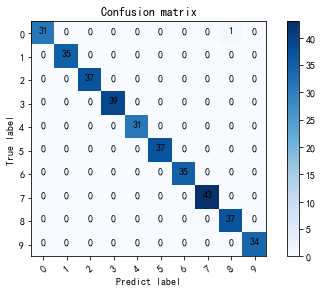

In [155]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))
# plt.savefig('Confusion matrix.jpg')

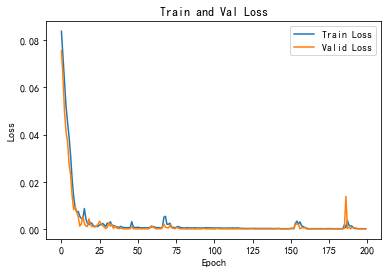

In [156]:
#迭代Loss图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(200)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
# plt.savefig('Train and Val Loss.jpg')
plt.show()

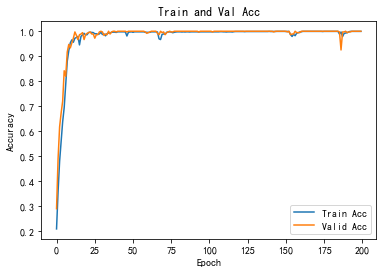

In [157]:
#迭代Acc图像
loss = history.history['acc']
val_loss = history.history['val_acc']
epochs_range = range(200)
plt.plot(epochs_range, loss, label='Train Acc')
plt.plot(epochs_range, val_loss, label='Valid Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Train and Val Acc')
# plt.savefig('Train and Val Acc_100.jpg')
plt.show()

In [158]:
loss, accuracy = model.evaluate(x=X_test, y=y_test, verbose=2)
print("测试集上的损失：", loss)
print("模型上的正确率:", accuracy)

测试集上的损失： 0.0005537385307502203
模型上的正确率: 0.9972222222222222


In [159]:
model1 = load_model('best_weights.hdf5')
loss, accuracy = model1.evaluate(x=X_test, y=y_test, verbose=2)
print("测试集上的损失：", loss)
print("模型上的正确率:", accuracy)

测试集上的损失： 0.0008433334933619739
模型上的正确率: 0.9944444444444445


### 绘制T-sne可视化效果图

In [160]:
# 定义data函数
def get_data():
    """
    :return: 数据集、标签、样本数量、特征数量
    """
    data = X_train # 数据：numpy.ndarray
    label = [np.argmax(one_hot)for one_hot in y_train] # 标签，不能用one-hot格式：list
    n_samples = 1680  # 对应reshape中的行数
    n_features = 250  # 对应reshape中的列数
    return data, label, n_samples, n_features

In [161]:
# 定义绘图函数
def plot_embedding(data, label, title):
    """
    :param data:数据集
    :param label:样本标签
    :param title:图像标题
    :return:图像
    """
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)  # 对数据进行归一化处理
    
    d = {'x': data[:, 0] , 'y': data[:, 1], 'label': label}# 将数据转换为DataFrame
    data = pd.DataFrame(data=d)
    
    fig = plt.figure()  # 创建图形实例
    sns.scatterplot(data=data, x='x', y='y', hue='label', palette=sns.color_palette("tab10"))
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

    plt.title(title, fontsize=14)
    # 返回值
    return fig


Starting compute t-SNE Embedding...


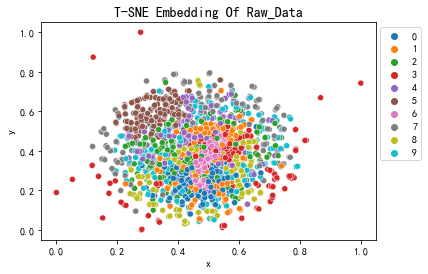

In [162]:
# 绘制原始数据T-SNE
data, label, n_samples, n_features = get_data()  # 调用函数，获取相关数据
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)
# t-SNE降维
reslut = ts.fit_transform(data)
# 调用函数，绘制图像
plot_embedding(reslut, label, 'T-SNE Embedding Of Raw_Data')
# plt.savefig('1T-SNE Embedding Of Raw_Data.png')
# 显示图像
plt.show()

Starting compute t-SNE Embedding...


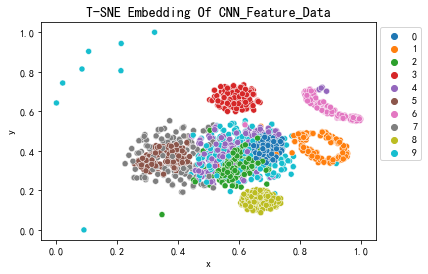

In [163]:
# 绘制特征融合后的T-SNE

eca_layer_model = Model(inputs=model.input, 
                    outputs=model.get_layer('multiply_1').output)
out = eca_layer_model.predict(data)

out_reshape = out.reshape((n_samples,-1))# 将层的输出结果进行reshape

print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)
# t-SNE降维
reslut = ts.fit_transform(out_reshape)
# 调用函数，绘制图像
fig = plot_embedding(reslut, label, 'T-SNE Embedding Of CNN_Feature_Data')
# plt.savefig('2T-SNE Embedding Of CNN_Feature_Data.png')
# 显示图像
plt.show()

Starting compute t-SNE Embedding...


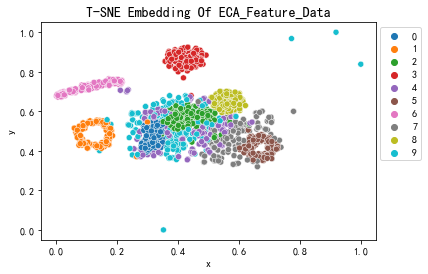

In [164]:
# 绘制融合后特征经过ECA模块的T-SNE

eca_layer_model = Model(inputs=model.input, 
                    outputs=model.get_layer('multiply_2').output)
out = eca_layer_model.predict(data)

out_reshape = out.reshape((n_samples,-1))# 将层的输出结果进行reshape

print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)
# t-SNE降维
reslut = ts.fit_transform(out_reshape)
# 调用函数，绘制图像
fig = plot_embedding(reslut, label, 'T-SNE Embedding Of ECA_Feature_Data')
# plt.savefig('3T-SNE Embedding Of ECA_Feature_Data.png')
# 显示图像
plt.show()

Starting compute t-SNE Embedding...


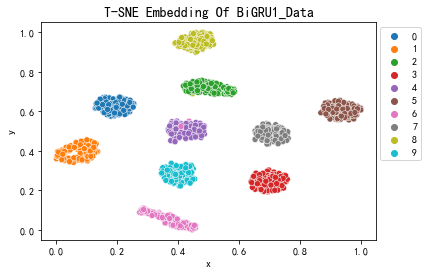

In [165]:
# 绘制BiGRU1的T-SNE

eca_layer_model = Model(inputs=model.input, 
                    outputs=model.get_layer('bidirectional_1').output)
out = eca_layer_model.predict(data)

out_reshape = out.reshape((n_samples,-1))# 将层的输出结果进行reshape

print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)
# t-SNE降维
reslut = ts.fit_transform(out_reshape)
# 调用函数，绘制图像
fig = plot_embedding(reslut, label, 'T-SNE Embedding Of BiGRU1_Data')
# plt.savefig('4T-SNE Embedding Of BiGRU1_Data.png')
# 显示图像
plt.show()

Starting compute t-SNE Embedding...


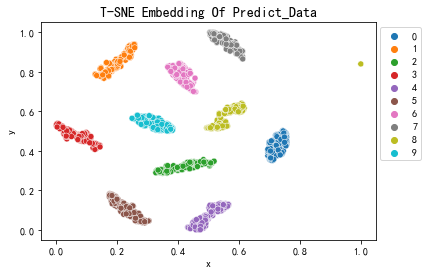

In [166]:
# 绘制经过model预测的T-SNE

predict_data = model.predict(data) # 这里的data即为原始数据，predict_data为预测结果
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)
# t-SNE降维
reslut = ts.fit_transform(predict_data)
# 调用函数，绘制图像
fig = plot_embedding(reslut, label, 'T-SNE Embedding Of Predict_Data')
# plt.savefig('5T-SNE Embedding Of Predict_Data.png')
# 显示图像
plt.show()


In [167]:
# 查看中间层的输出可视化

In [168]:
layer_outputs = [layer.output for layer in model.layers[1:24]]
layer_outputs

[<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 250, 1) dtype=float32>,
 <tf.Tensor 'conv1d_3/Tanh:0' shape=(?, 245, 50) dtype=float32>,
 <tf.Tensor 'conv1d_4/Tanh:0' shape=(?, 240, 40) dtype=float32>,
 <tf.Tensor 'max_pooling1d_2/Squeeze:0' shape=(?, 120, 40) dtype=float32>,
 <tf.Tensor 'conv1d_1/Tanh:0' shape=(?, 116, 50) dtype=float32>,
 <tf.Tensor 'conv1d_5/Tanh:0' shape=(?, 115, 30) dtype=float32>,
 <tf.Tensor 'conv1d_2/Tanh:0' shape=(?, 54, 30) dtype=float32>,
 <tf.Tensor 'conv1d_6/Tanh:0' shape=(?, 55, 30) dtype=float32>,
 <tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 54, 30) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/cond/Merge:0' shape=(?, 55, 30) dtype=float32>,
 <tf.Tensor 'max_pooling1d_1/Squeeze:0' shape=(?, 27, 30) dtype=float32>,
 <tf.Tensor 'max_pooling1d_3/Squeeze:0' shape=(?, 27, 30) dtype=float32>,
 <tf.Tensor 'multiply_1/mul:0' shape=(?, 27, 30) dtype=float32>,
 <tf.Tensor 'global_average_pooling1d_1/Mean:0' shape=(?, 30) dtype=float32>,
 <tf.Tensor 

In [169]:
# 给定模型输入，创建将返回这些输出的模型
# input_seq = Input(shape=(250,))
activation_model = Model(inputs=model.input, outputs=layer_outputs)
one_datas = np.expand_dims(X_test[1],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

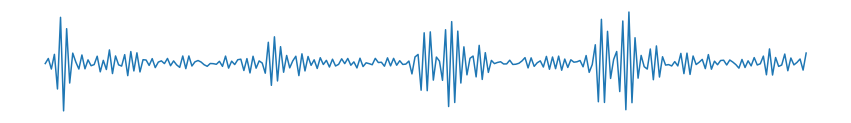

In [170]:
plt.figure(figsize=(15,2))
plt.plot(X_test[1])
plt.axis('off')
plt.show()

In [171]:
# print(activations[0].shape) # reshape层
# plt.matshow(activations[0][0], cmap='viridis')
# plt.axis('off')
# plt.show()

(1, 116, 50)


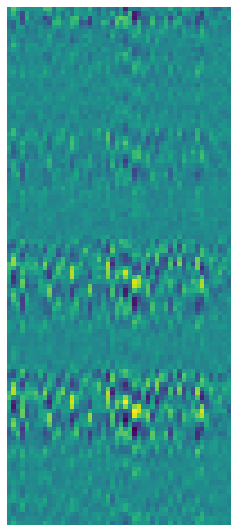

In [172]:
print(activations[4].shape) # A的第一次卷积
plt.matshow(activations[4][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 54, 30)


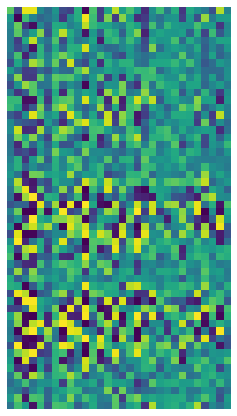

In [173]:
print(activations[6].shape) # A的第二次卷积
plt.matshow(activations[6][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 54, 30)


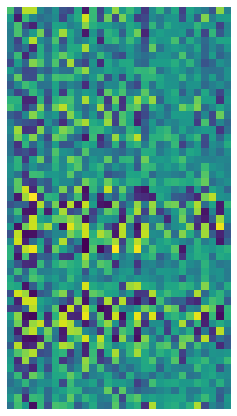

In [174]:
print(activations[8].shape) # A的第一次BN
plt.matshow(activations[8][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 27, 30)


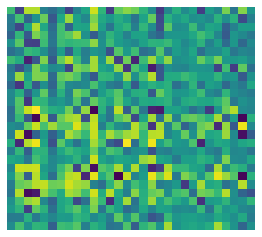

In [175]:
print(activations[10].shape) # A的第一次池化
plt.matshow(activations[10][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 245, 50)


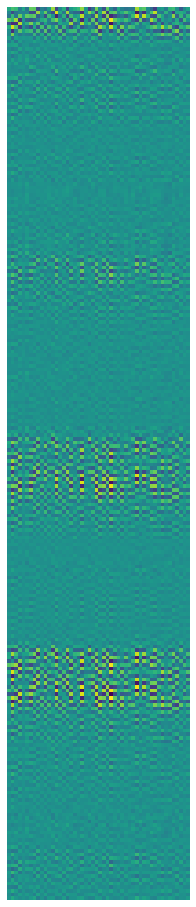

In [176]:
print(activations[1].shape) # B的第一次卷积
plt.matshow(activations[1][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 240, 40)


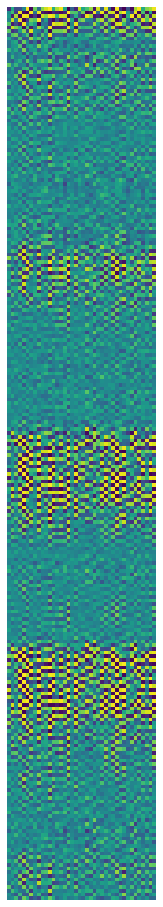

In [177]:
print(activations[2].shape) # B的第二次卷积
plt.matshow(activations[2][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 120, 40)


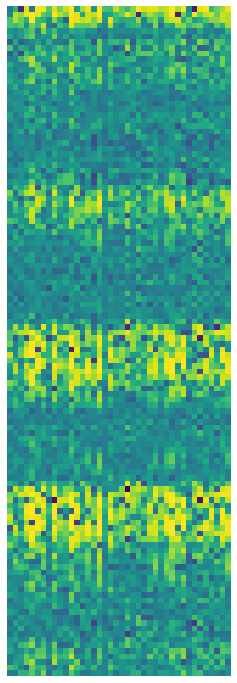

In [178]:
print(activations[3].shape) # B的第一次池化
plt.matshow(activations[3][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 115, 30)


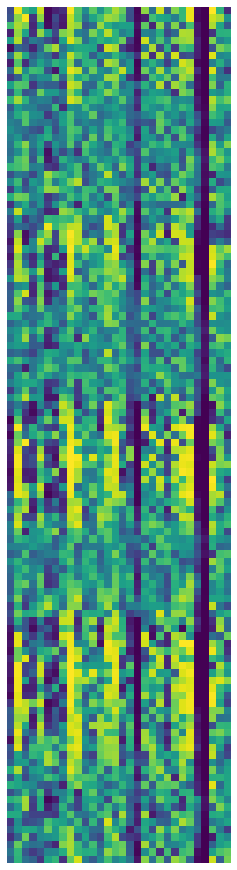

In [179]:
print(activations[5].shape) # B的第三次卷积
plt.matshow(activations[5][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 55, 30)


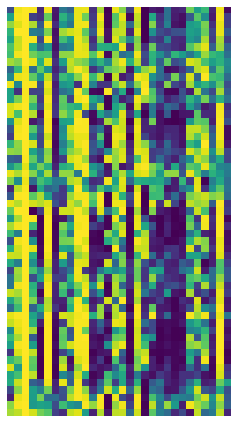

In [180]:
print(activations[7].shape) # B的第四次卷积
plt.matshow(activations[7][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 55, 30)


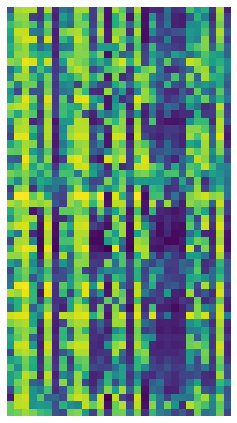

In [181]:
print(activations[9].shape) # B的第一次BN
plt.matshow(activations[9][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 27, 30)


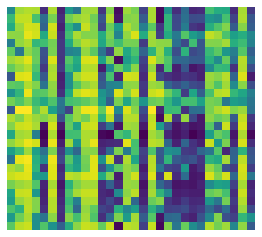

In [182]:
print(activations[11].shape) # B的第二次池化
plt.matshow(activations[11][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 27, 30)


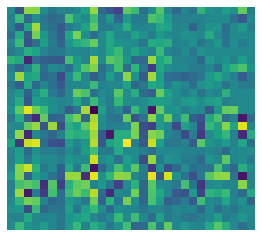

In [183]:
print(activations[12].shape) # AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 30)


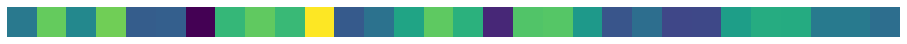

In [184]:
print(activations[13].shape) # ECA 全局池化
plt.matshow(activations[13], cmap='viridis')
plt.axis('off')
plt.show()

(1, 30, 1)


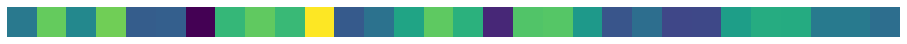

In [185]:
print(activations[14].shape) # ECA reshape
plt.matshow(activations[14], cmap='viridis')
plt.axis('off')
plt.show()

(1, 30, 1)


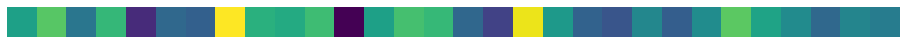

In [186]:
print(activations[15].shape) # ECA 卷积
plt.matshow(activations[15], cmap='viridis')
plt.axis('off')
plt.show()

(1, 30, 1)


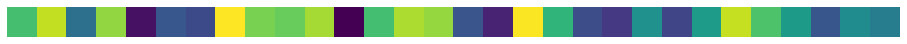

In [187]:
print(activations[16].shape) # ECA 激活函数
plt.matshow(activations[16], cmap='viridis')
plt.axis('off')
plt.show()

(1, 1, 30)


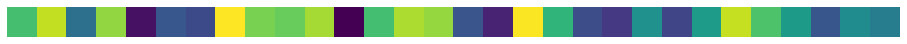

In [188]:
print(activations[17].shape) #  ECA 第二次reshape
plt.matshow(activations[17][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 27, 30)


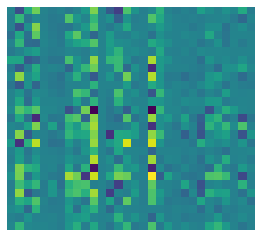

In [189]:
print(activations[18].shape) # ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.show()

(1, 27, 60)


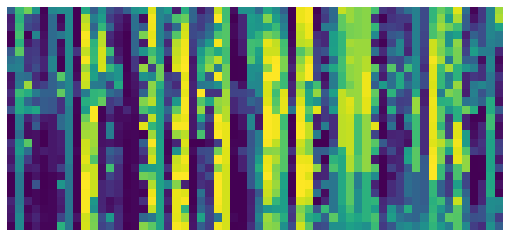

In [190]:
print(activations[19].shape) # 第一层 BiGRU
plt.matshow(activations[19][0], cmap='viridis')
plt.axis('off')
plt.show()

In [191]:
print(activations[20].shape) # 第二层 BiGRU
plt.matshow(activations[20], cmap='viridis')
plt.axis('off')
plt.show()

(1, 60)


In [192]:
print(activations[21].shape) # dropout层
plt.matshow(activations[21], cmap='viridis')
plt.axis('off')
plt.show()

(1, 60)


(1, 10)


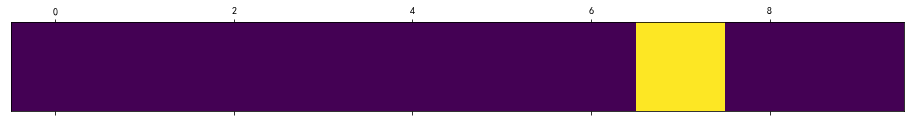

In [193]:
print(activations[22].shape) # dense 输出层

plt.matshow(activations[22], cmap='viridis', aspect=1)

plt.yticks([])
# plt.savefig('16.jpg')
plt.show()

In [194]:
y = np.argmax(y_test[1])
y

7

In [195]:
# # 保存模型结构及shape尺寸
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='model_summary_shape.png')

### 绘制十种信号的融合特征与经过ECA处理的融合特征

In [196]:
# y = np.argmax(y_test[3])===0
# y = np.argmax(y_test[0])===1
# y = np.argmax(y_test[14])===2
# y = np.argmax(y_test[8])===3
# y = np.argmax(y_test[5])===4
# y = np.argmax(y_test[4])===5
# y = np.argmax(y_test[31])===6
# y = np.argmax(y_test[1])===7
# y = np.argmax(y_test[10])===8
# y = np.argmax(y_test[7])===9

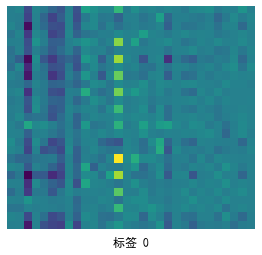

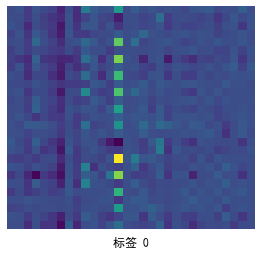

In [197]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[3],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.axis('off')
plt.title('标签 0', y=-0.1)
# plt.savefig('标签0-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 0', y=-0.1)
# plt.savefig('标签0-ECA-feature.png')
plt.show()

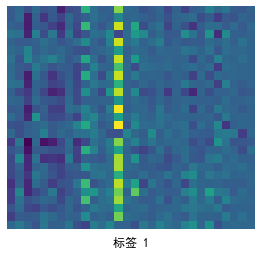

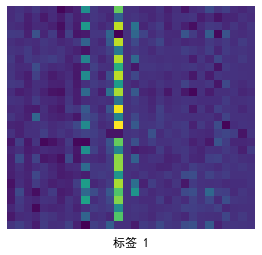

In [198]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[0],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 1', y=-0.1)
# plt.savefig('标签1-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 1', y=-0.1)
# plt.savefig('标签1-ECA-feature.png')
plt.show()

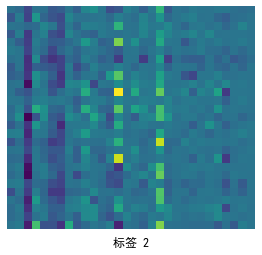

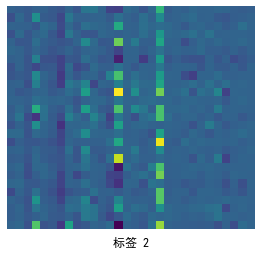

In [199]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[14],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 2', y=-0.1)
# plt.savefig('标签2-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 2', y=-0.1)
# plt.savefig('标签2-ECA-feature.png')
plt.show()

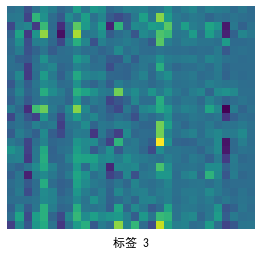

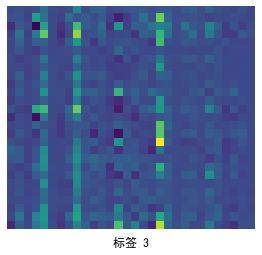

In [200]:
one_datas = np.expand_dims(X_test[8],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 3', y=-0.1)
# plt.savefig('标签3-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 3', y=-0.1)
# plt.savefig('标签3-ECA-feature.png')
plt.show()

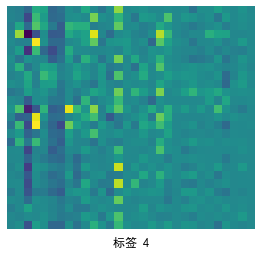

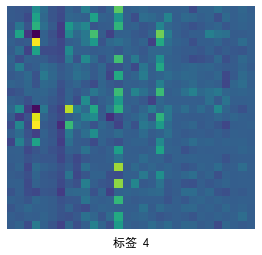

In [201]:
one_datas = np.expand_dims(X_test[5],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 4', y=-0.1)
# plt.savefig('标签4-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 4', y=-0.1)
# plt.savefig('标签4-ECA-feature.png')
plt.show()

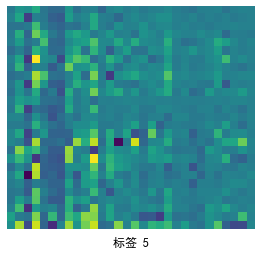

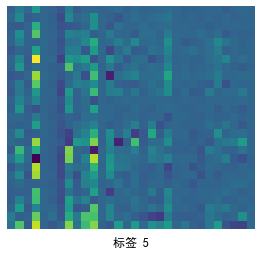

In [202]:
one_datas = np.expand_dims(X_test[4],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 5', y=-0.1)
# plt.savefig('标签5-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 5', y=-0.1)
# plt.savefig('标签5-ECA-feature.png')
plt.show()

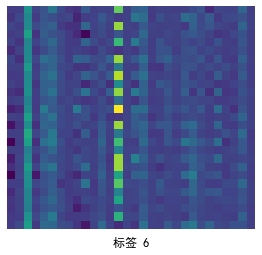

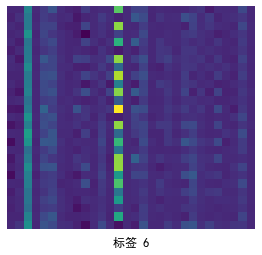

In [203]:
one_datas = np.expand_dims(X_test[31],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 6', y=-0.1)
# plt.savefig('标签6-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 6', y=-0.1)
# plt.savefig('标签6-ECA-feature.png')
plt.show()

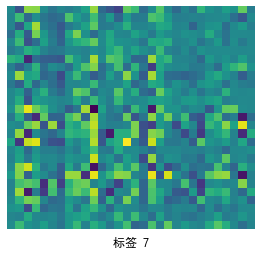

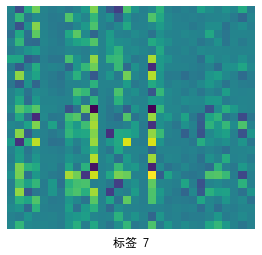

In [204]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[1],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 7', y=-0.1)
# plt.savefig('标签7-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 7', y=-0.1)
# plt.savefig('标签7-ECA-feature.png')
plt.show()

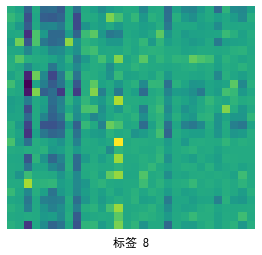

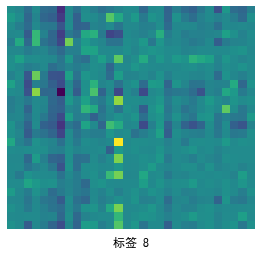

In [205]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[10],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 8', y=-0.1)
# plt.savefig('标签8-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 8', y=-0.1)
# plt.savefig('标签8-ECA-feature.png')
plt.show()

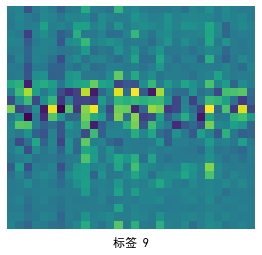

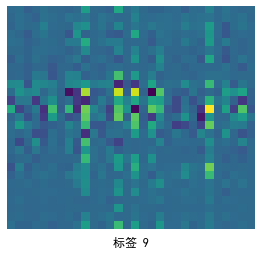

In [206]:
# 每次都要更改输入的数据，对应十个标签
one_datas = np.expand_dims(X_test[7],axis=0) # 增加一个维度
activations = activation_model.predict(one_datas)

# AB卷积的融合特征
plt.matshow(activations[12][0], cmap='viridis')
plt.axis('off')
plt.title('标签 9', y=-0.1)
# plt.savefig('标签9-feature.png')
plt.show()

# ECA与特征融合后的特征
plt.matshow(activations[18][0], cmap='viridis')
plt.axis('off')
plt.title('标签 9', y=-0.1)
# plt.savefig('标签9-ECA-feature.png')
plt.show()